## A program to test filtering programs in python
Dennis L. Hartmann Feb. 22, 2023 </br>
Testing for ATMS 552 </br>
scipy.signal.butter(N, Wn, btype='low', analog=False, output='ba', fs=None)</br>
N is the order of the filter</br>
Wn if a scalar, is the location in the Nyquist interval where the cut is placed 0 < Wn < 1</br>
For bandpass and stop Wn is an array with two cuts on the Nyquist interval</br>
btype{‘lowpass’, ‘highpass’, ‘bandpass’, ‘bandstop’}, optional</br>



In [71]:
#import math
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from scipy import stats

(0.0, 0.3)

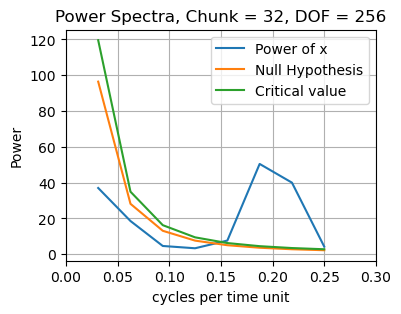

In [75]:
# let's try to read x552filt data set

mat = scipy.io.loadmat('data/x552filt.mat')
x = mat.get('x552filt')

xshape = np.shape(x)
x = x - np.mean(x)
x=np.reshape(x,xshape[0])
# compute power spectrum
p_crit=0.99
def acor(x):
    xd = (x -np.mean(x))/np.std(x)
    acor = np.dot(xd[0:len(xd)-1],xd[1:len(x)])/(len(xd)-1)
    #acor = np.sqrt(acor)
    return acor
acx = acor(x)
M_window = 32
f, Pxx = signal.welch(x,nperseg=M_window,noverlap=M_window/2,detrend='linear')
#f=f/(2.*np.pi)
def red_shape(f,ac,A):
    rs = A*(1.0-ac**2)/(1. -(2.0*ac*np.cos(f*2.0*np.pi))+ac**2)
    return rs
# compute the Gilman et al shape for red noise
rs_x = red_shape(f,acx,1.0)

# normalize Gilman Shape
rsx = rs_x*np.sum(Pxx[1:len(Pxx)])/np.sum(rs_x[1:len(rs_x)]) # compute rs matched to Pxx 

nun = 2.0*len(x)/M_window   # DOF of spectrum conservative estimate
dun = len(x)/2  # DOF of denominator Null Hypothesis

def get_fcrit(p_crit,nun,dun):
    for n in range(200):
        f=1.+float(n)/50.
        p_val = stats.f.cdf(f,nun,dun)
        if p_val > p_crit:
            f_crit = f
            break
    return f_crit
f_critx = get_fcrit(p_crit,nun,dun)

rsxs = rsx*f_critx  # computing the line we need to exceed Red Noise Theory
ifrac = 0.6   # we are only plotting ifrac of the Nyquist interval
ifx = int(ifrac*M_window/2)
plt.figure(figsize=(4,3))
plt.plot(f[1:ifx],Pxx[1:ifx],f[1:ifx],rsx[1:ifx],f[1:ifx],rsxs[1:ifx])
plt.xlabel('cycles per time unit')
plt.ylabel('Power')
plt.legend(['Power of x','Null Hypothesis','Critical value'])
plt.grid()
plt.title('Power Spectra, Chunk = '+str(M_window) + ', DOF = '+str(int(nun)))
plt.xlim(0.,0.5*ifrac)

## Design a filter to separate the low frequencies from the 5-"day" cycle
From the above spectrum we can see that we have red noise, plus a 5 time unit wave.</br>
But we can't see if there is any relationship between the low-frequencies and the high frequencies
We'll cut just below 0.2 cycles per "day"

type h1, w  <class 'numpy.ndarray'> <class 'numpy.ndarray'>


(0.0, 0.5)

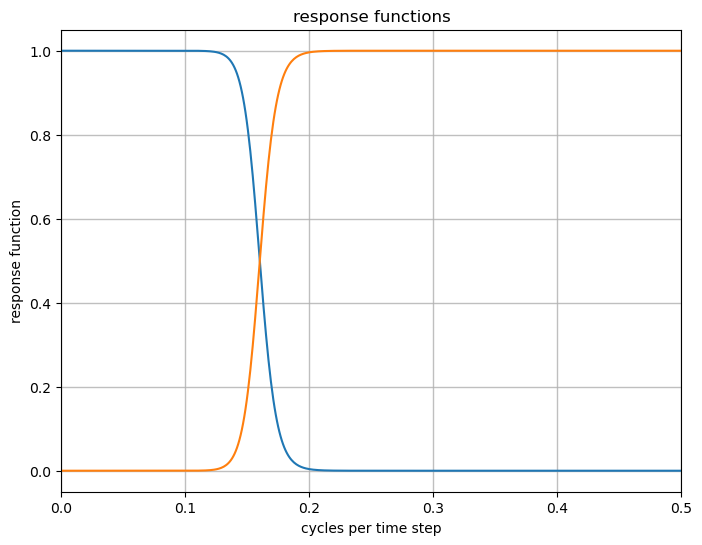

In [76]:
# filter into two parts, less than 10 days and greater than 10 days  f=1/10 is 0.2 of nyquist interval
N = 10
Wn= 0.32
b, a = signal.butter(N, Wn, 'low')
w, h1 = signal.freqz(b, a)
xlow = signal.filtfilt(b,a,x)
Wn= 0.32
b, a = signal.butter(N, Wn, 'high')
w, h2 = signal.freqz(b, a)
xhi = signal.filtfilt(b,a,x)
w = w/(2.*np.pi)
plt.figure(figsize=(8,6))
plt.plot(w,h1*np.conjugate(h1),w,h2*np.conjugate(h2))
print('type h1, w ',type(h1),type(w))
plt.title('response functions')
plt.grid('on',alpha=0.8,linewidth=1.0)
plt.xlabel('cycles per time step')
plt.ylabel('response function')
plt.xlim(0.0, 0.5)

## Next plot the low-pass and high-pass data together
We notice that the high pass variance is large, wheh the low pass field is near zero. </br>
Spectral analysis cannot show this, because all phase information is lost</br>
We just know from spectral analysis that we have red noise and a periodicity at 5 time units.

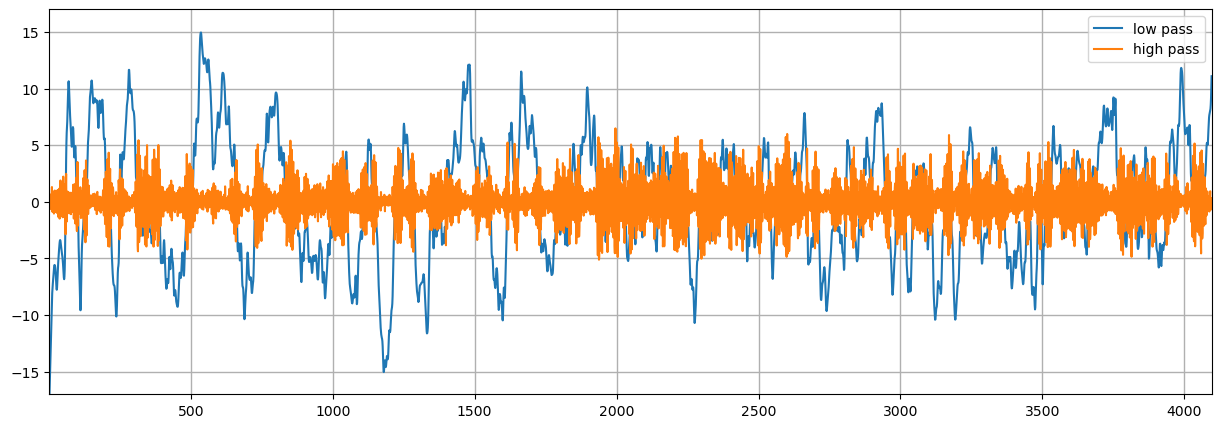

In [78]:

# plot low and high pass filtered data
#time = np.arange([1,len(x),1])
time = np.linspace(1,len(x),len(x),dtype='float')
plt.figure(figsize=(15,5))
plt.plot(time,xlow,time,xhi)
plt.legend(['low pass','high pass'])
plt.xlim(1.,len(x))
plt.grid('on',linewidth=1)
plt.ylim(-17.,17.)
plt.show()

### Finally, to emphasize the point, we make a scatter plot of the absolute value of the high frequency signal versus the low frequency signal.
We see that the high frequency signal is only really large when the low frequency signal is near zero.

shape xhisq  (4096,)


Text(0, 0.5, 'xhigh')

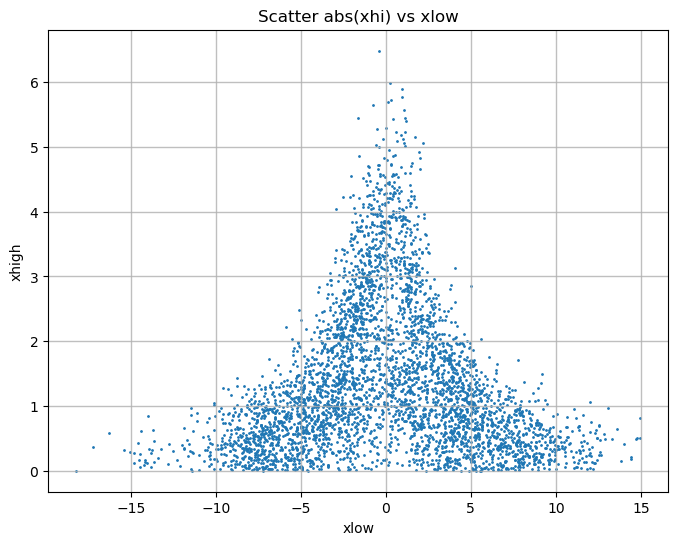

In [79]:
# make scatter plot of abs(high) versus low signals
#xhisq = np.multiply(xhi,xhi)
print('shape xhisq ',np.shape(xhisq))
plt.figure(figsize=(8,6))
plt.scatter(xlow,np.abs(xhi),s=1)
plt.title('Scatter abs(xhi) vs xlow')
plt.grid('on',alpha=0.8,linewidth=1.0)
plt.xlabel('xlow')
plt.ylabel('xhigh')


## Next we consider the utility of filtering to separate the time dependence of the 100kyr and 40kyr signals in the benthic deltaO18 record

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Mon Mar  2 17:29:36 2020', '__version__': '1.0', '__globals__': [], 'nt': array([[   0,    1,    2, ..., 5318, 5319, 5320]], dtype=uint16), 'o18i': array([[3.23 , 3.23 , 3.18 , ..., 2.882, 2.896, 2.91 ]])}
type <class 'dict'>
1
xshape  (1, 5321)
delt  1
type h, w  <class 'numpy.ndarray'> <class 'numpy.ndarray'>


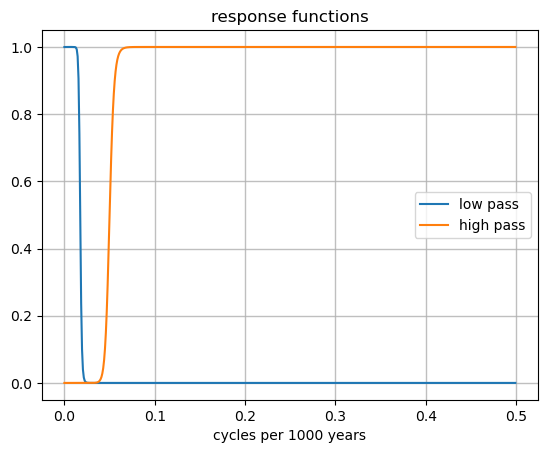

In [80]:
# OK, let's try something real
# try loading Raymo_2005Int.mat, or x552filt or raymo.dat
# data set is the benthic O18 record fir the past 5.2 million years from Raymo and Lisieki(2005)
mat = scipy.io.loadmat('data/Raymo_2005Int.mat')
# I think this has been interpolated to a time step of 1000 years
print(mat)
print('type', type(mat))
time = mat.get('nt')
x = mat.get('o18i')
print(len(x))
xshape = np.shape(x)
print('xshape ',xshape)
x=np.reshape(x,xshape[1])
time=np.reshape(time,xshape[1])
print('delt ',time[2]-time[1])

# Nyquist is 1/2000 years, bandwidth is 1/1000 years, Wn = 0.5 is 1/4000 years, Wn = 0.1 is 1/20000 years, Wn = 0.05 is 1/40000 years
# Wn = 0.02 is 1/100,000 years, 0.03 is 1/66,000 years, 0.04 is 1/50,000 years. 
# 0.035 seems like a good choice to cut betweeen 100,000 and 40,000 year periods

N = 10
Wn= 0.035
b, a = signal.butter(N, Wn, 'low')
w, h1 = signal.freqz(b, a)
xlow = signal.filtfilt(b,a,x)
Wn= 0.035
b, a = signal.butter(N, Wn, 'high')
w, h = signal.freqz(b, a)
xhi = signal.filtfilt(b,a,x)


Wn = 0.1
b, a = signal.butter(N, Wn, 'high')
w, h2 = signal.freqz(b, a)
xvhi = signal.filtfilt(b,a,x)
w = w/(np.pi*2.0)
plt.figure()
plt.plot(w,h1*np.conjugate(h1),w,h2*np.conjugate(h2))
print('type h, w ',type(h),type(w))
plt.title('response functions')
plt.grid('on',alpha=0.8,linewidth=1.0)
plt.xlabel('cycles per 1000 years')
plt.legend(['low pass','high pass'])
x40 = xhi - xvhi

### make a plot versus time of the original data and the low-pass filtered version, then the 40kyr band-pass filtered 

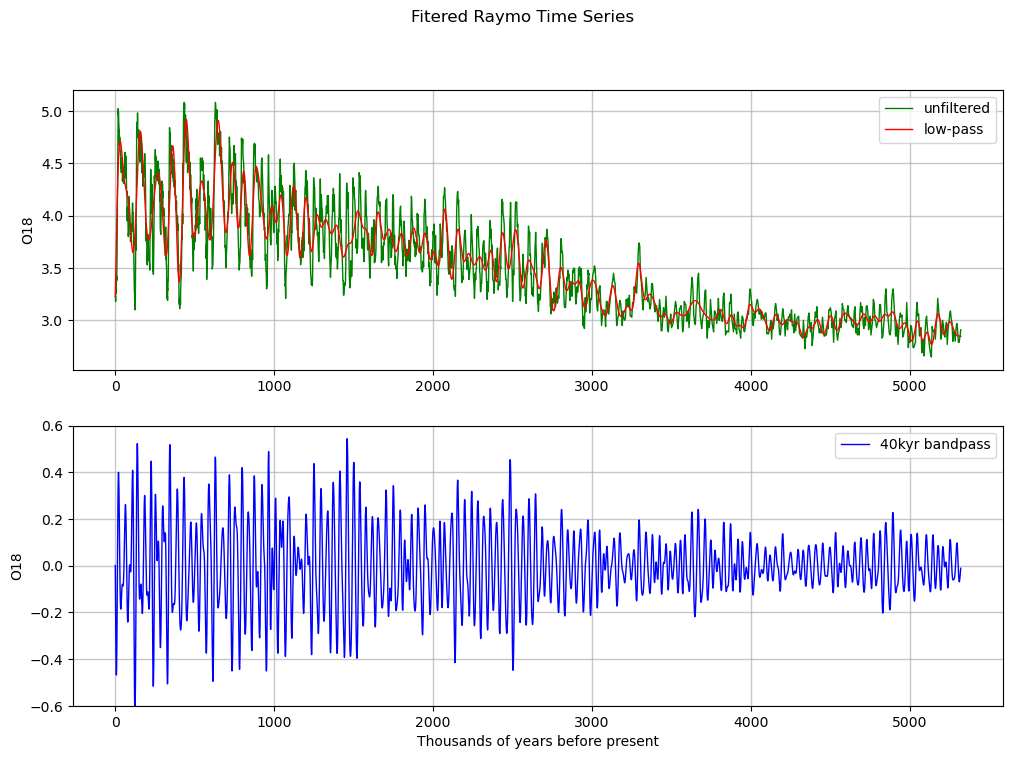

In [81]:


fig, axs = plt.subplots(2, figsize=(12,8))
fig.suptitle('Fitered Raymo Time Series')
axs[0].plot(time,x,"g-",time,xlow,"r-",linewidth=1.0)
plt.ylabel('O18')
axs[0].legend(['unfiltered','low-pass'])
axs[0].grid('on', alpha=0.7,linewidth=1.0)
axs[1].plot(time,x40,"b-",linewidth=1.0)
plt.ylabel('O18')
plt.xlabel('Thousands of years before present')
plt.grid('on', alpha=0.7,linewidth=1.0)
plt.ylabel('O18')
plt.legend(['40kyr bandpass'])
plt.xlabel('Thousands of years before present')
plt.grid('on', alpha=0.7,linewidth=1.0)
plt.ylim(-0.6, 0.6)
for ax in axs.flat:
    ax.set( ylabel='O18')
plt.show()
